## Imports

In [2]:

import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Model Settings

In [3]:
RANDOM_SEED = 1
LEARNING_RATE = 0.000001
BATCH_SIZE = 32
NUM_EPOCHS = 20

RESOLUTION = 200
NUM_FEATURES = RESOLUTION*RESOLUTION
NUM_CLASSES = 66

DEVICE = "cuda:0"
GRAYSCALE = False

In [5]:
transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

path = 'CV_data/Extracted_dataset_input_combined'
dataset = datasets.ImageFolder(root=path, transform=transform)


# Get class to index mapping
class_to_idx = dataset.class_to_idx

# Define index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training set and test set
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels)
    break


Image batch dimensions: torch.Size([32, 3, 200, 200])
Image label dimensions: torch.Size([32])
Labels: tensor([35, 60, 43, 33, 44, 47,  0,  5,  2,  0, 44, 39, 54, 44, 22, 36, 25, 25,
        43,  1, 48, 14,  0, 11, 25,  6, 61, 61, 28, 43, 65, 11])


In [6]:
from collections import Counter


train_classes = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1 / torch.tensor(list(dict(sorted(dict(Counter(train_classes)).items())).values()))
class_weights

tensor([0.0003, 0.0026, 0.0013, 0.0008, 0.0024, 0.0005, 0.0016, 0.0159, 0.0015,
        0.0147, 0.0017, 0.0004, 0.0030, 0.0086, 0.0013, 0.0067, 0.0013, 0.0152,
        0.0024, 0.0033, 0.0031, 0.0156, 0.0035, 0.0009, 0.0013, 0.0006, 0.0026,
        0.0027, 0.0026, 0.0022, 0.0027, 0.0064, 0.0016, 0.0149, 0.0025, 0.0027,
        0.0013, 0.0068, 0.0032, 0.0013, 0.0009, 0.0023, 0.0025, 0.0007, 0.0002,
        0.0154, 0.0066, 0.0013, 0.0011, 0.0073, 0.0022, 0.0011, 0.0026, 0.0169,
        0.0024, 0.0026, 0.0154, 0.0145, 0.0027, 0.0068, 0.0023, 0.0006, 0.0019,
        0.0137, 0.0017, 0.0108])

In [7]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# Model

In [8]:

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet50(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [9]:
torch.manual_seed(RANDOM_SEED)

model = resnet50(NUM_CLASSES)
model.to(DEVICE)
 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [10]:
def compute_accuracy(model, data_loader, device, mode="train"):
    correct_pred, num_examples = 0, 0
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
        if not batch_idx % 50:
            accuracy = correct_pred.float() / num_examples * 100
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-accuracy.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {accuracy}\n")
            correct_pred, num_examples = 0, 0



In [11]:
def compute_loss(model, data_loader, class_weights, device, mode="val"):
    losses = []
    dataset_len = len(data_loader)
    for batch_idx, (features, targets) in tqdm(enumerate(data_loader)):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        class_weights = class_weights.to(DEVICE)
            
        logits, _ = model(features)
        loss = F.cross_entropy(logits, targets, weight=class_weights)
        losses.append(loss)
        
        if not batch_idx % 50:
            mean_loss = sum(losses) / len(losses)
            with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-{mode}-loss.csv', 'a') as fp:
                fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
            losses.clear()

## Training

In [ ]:
model_name = "03-model"

In [11]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
        model.train()
        losses = []
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            class_weights = class_weights.to(DEVICE)

            ### FORWARD AND BACK PROP
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, weight=class_weights)
            losses.append(loss)

            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                       %(epoch+1, NUM_EPOCHS, batch_idx,
                         len(train_loader), loss))

                mean_loss = sum(losses) / len(losses)
                with open(f'CV_data/models/{model_name}-{LEARNING_RATE}-train-loss.csv', 'a') as fp:
                    fp.write(f"{epoch+1}, {batch_idx}, {mean_loss}\n")
                losses.clear()


        model.eval()
        with torch.set_grad_enabled(False): # save memory during inference
            compute_accuracy(model, train_loader, device=DEVICE, mode="train")
            compute_loss(model, val_loader, class_weights, device=DEVICE, mode="val")
            compute_accuracy(model, val_loader, device=DEVICE, mode="val")

        file_path = f'CV_data/models/{model_name}-{LEARNING_RATE}-epoch{epoch+1}.pth'
        torch.save(model.state_dict(), file_path)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/1284 | Cost: 4.3191
Epoch: 001/020 | Batch 0050/1284 | Cost: 3.8784
Epoch: 001/020 | Batch 0100/1284 | Cost: 3.2040
Epoch: 001/020 | Batch 0150/1284 | Cost: 3.4764


/data/leuven/354/vsc35486/miniconda3/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 001/020 | Batch 0200/1284 | Cost: 2.5089
Epoch: 001/020 | Batch 0250/1284 | Cost: 2.1263
Epoch: 001/020 | Batch 0300/1284 | Cost: 1.5152
Epoch: 001/020 | Batch 0350/1284 | Cost: 1.8186
Epoch: 001/020 | Batch 0400/1284 | Cost: 1.5093
Epoch: 001/020 | Batch 0450/1284 | Cost: 1.1814
Epoch: 001/020 | Batch 0500/1284 | Cost: 1.1704
Epoch: 001/020 | Batch 0550/1284 | Cost: 1.0169
Epoch: 001/020 | Batch 0600/1284 | Cost: 0.6053
Epoch: 001/020 | Batch 0650/1284 | Cost: 1.0494
Epoch: 001/020 | Batch 0700/1284 | Cost: 0.4797
Epoch: 001/020 | Batch 0750/1284 | Cost: 1.1085
Epoch: 001/020 | Batch 0800/1284 | Cost: 0.8728
Epoch: 001/020 | Batch 0850/1284 | Cost: 1.1483
Epoch: 001/020 | Batch 0900/1284 | Cost: 1.6019
Epoch: 001/020 | Batch 0950/1284 | Cost: 0.2211
Epoch: 001/020 | Batch 1000/1284 | Cost: 0.9560
Epoch: 001/020 | Batch 1050/1284 | Cost: 0.2717
Epoch: 001/020 | Batch 1100/1284 | Cost: 0.8730
Epoch: 001/020 | Batch 1150/1284 | Cost: 0.9638
Epoch: 001/020 | Batch 1200/1284 | Cost:

1284it [01:52, 11.44it/s]
428it [00:43,  9.81it/s]
428it [00:37, 11.52it/s]


Time elapsed: 7.50 min
Epoch: 002/020 | Batch 0000/1284 | Cost: 0.2096
Epoch: 002/020 | Batch 0050/1284 | Cost: 0.1941
Epoch: 002/020 | Batch 0100/1284 | Cost: 0.3574
Epoch: 002/020 | Batch 0150/1284 | Cost: 0.1518
Epoch: 002/020 | Batch 0200/1284 | Cost: 0.6693
Epoch: 002/020 | Batch 0250/1284 | Cost: 0.5049
Epoch: 002/020 | Batch 0300/1284 | Cost: 0.2716
Epoch: 002/020 | Batch 0350/1284 | Cost: 0.9986
Epoch: 002/020 | Batch 0400/1284 | Cost: 0.1063
Epoch: 002/020 | Batch 0450/1284 | Cost: 0.9713
Epoch: 002/020 | Batch 0500/1284 | Cost: 0.1949
Epoch: 002/020 | Batch 0550/1284 | Cost: 1.5531
Epoch: 002/020 | Batch 0600/1284 | Cost: 0.1839
Epoch: 002/020 | Batch 0650/1284 | Cost: 0.2158
Epoch: 002/020 | Batch 0700/1284 | Cost: 0.1884
Epoch: 002/020 | Batch 0750/1284 | Cost: 0.3458
Epoch: 002/020 | Batch 0800/1284 | Cost: 0.1355
Epoch: 002/020 | Batch 0850/1284 | Cost: 0.7426
Epoch: 002/020 | Batch 0900/1284 | Cost: 0.9803
Epoch: 002/020 | Batch 0950/1284 | Cost: 0.6367
Epoch: 002/020 | 

1284it [01:51, 11.49it/s]
428it [00:36, 11.67it/s]
428it [00:36, 11.82it/s]


Time elapsed: 14.40 min
Epoch: 003/020 | Batch 0000/1284 | Cost: 0.2136
Epoch: 003/020 | Batch 0050/1284 | Cost: 0.6090
Epoch: 003/020 | Batch 0100/1284 | Cost: 0.5652
Epoch: 003/020 | Batch 0150/1284 | Cost: 0.3366
Epoch: 003/020 | Batch 0200/1284 | Cost: 0.1955
Epoch: 003/020 | Batch 0250/1284 | Cost: 0.2393
Epoch: 003/020 | Batch 0300/1284 | Cost: 0.2758
Epoch: 003/020 | Batch 0350/1284 | Cost: 0.7816
Epoch: 003/020 | Batch 0400/1284 | Cost: 0.4737
Epoch: 003/020 | Batch 0450/1284 | Cost: 0.0517
Epoch: 003/020 | Batch 0500/1284 | Cost: 1.1495
Epoch: 003/020 | Batch 0550/1284 | Cost: 0.1640
Epoch: 003/020 | Batch 0600/1284 | Cost: 1.6745
Epoch: 003/020 | Batch 0650/1284 | Cost: 1.0454
Epoch: 003/020 | Batch 0700/1284 | Cost: 0.3805
Epoch: 003/020 | Batch 0750/1284 | Cost: 0.1762
Epoch: 003/020 | Batch 0800/1284 | Cost: 0.1786
Epoch: 003/020 | Batch 0850/1284 | Cost: 0.0678
Epoch: 003/020 | Batch 0900/1284 | Cost: 0.9274
Epoch: 003/020 | Batch 0950/1284 | Cost: 0.8646
Epoch: 003/020 |

1284it [01:51, 11.56it/s]
428it [00:38, 11.16it/s]
428it [00:37, 11.43it/s]


Time elapsed: 21.42 min
Epoch: 004/020 | Batch 0000/1284 | Cost: 1.2647
Epoch: 004/020 | Batch 0050/1284 | Cost: 0.1044
Epoch: 004/020 | Batch 0100/1284 | Cost: 0.5401
Epoch: 004/020 | Batch 0150/1284 | Cost: 0.8915
Epoch: 004/020 | Batch 0200/1284 | Cost: 0.4932
Epoch: 004/020 | Batch 0250/1284 | Cost: 0.2389
Epoch: 004/020 | Batch 0300/1284 | Cost: 0.2557
Epoch: 004/020 | Batch 0350/1284 | Cost: 0.1344
Epoch: 004/020 | Batch 0400/1284 | Cost: 1.4595
Epoch: 004/020 | Batch 0450/1284 | Cost: 0.0184
Epoch: 004/020 | Batch 0500/1284 | Cost: 0.1094
Epoch: 004/020 | Batch 0550/1284 | Cost: 0.4607
Epoch: 004/020 | Batch 0600/1284 | Cost: 0.6110
Epoch: 004/020 | Batch 0650/1284 | Cost: 0.2765
Epoch: 004/020 | Batch 0700/1284 | Cost: 0.0632
Epoch: 004/020 | Batch 0750/1284 | Cost: 0.0791
Epoch: 004/020 | Batch 0800/1284 | Cost: 0.0833
Epoch: 004/020 | Batch 0850/1284 | Cost: 0.0296
Epoch: 004/020 | Batch 0900/1284 | Cost: 0.1377
Epoch: 004/020 | Batch 0950/1284 | Cost: 0.4135
Epoch: 004/020 |

1284it [02:00, 10.64it/s]
428it [00:39, 10.80it/s]
428it [00:39, 10.73it/s]


Time elapsed: 29.03 min
Epoch: 005/020 | Batch 0000/1284 | Cost: 0.5708
Epoch: 005/020 | Batch 0050/1284 | Cost: 0.1668
Epoch: 005/020 | Batch 0100/1284 | Cost: 0.3304
Epoch: 005/020 | Batch 0150/1284 | Cost: 0.8629
Epoch: 005/020 | Batch 0200/1284 | Cost: 0.9947
Epoch: 005/020 | Batch 0250/1284 | Cost: 0.0226
Epoch: 005/020 | Batch 0300/1284 | Cost: 0.2709
Epoch: 005/020 | Batch 0350/1284 | Cost: 0.1108
Epoch: 005/020 | Batch 0400/1284 | Cost: 0.1224
Epoch: 005/020 | Batch 0450/1284 | Cost: 0.0905
Epoch: 005/020 | Batch 0500/1284 | Cost: 0.4918
Epoch: 005/020 | Batch 0550/1284 | Cost: 0.4161
Epoch: 005/020 | Batch 0600/1284 | Cost: 0.0291
Epoch: 005/020 | Batch 0650/1284 | Cost: 0.5581
Epoch: 005/020 | Batch 0700/1284 | Cost: 1.3333
Epoch: 005/020 | Batch 0750/1284 | Cost: 0.0868
Epoch: 005/020 | Batch 0800/1284 | Cost: 0.0291
Epoch: 005/020 | Batch 0850/1284 | Cost: 0.0227
Epoch: 005/020 | Batch 0900/1284 | Cost: 0.1077
Epoch: 005/020 | Batch 0950/1284 | Cost: 0.5397
Epoch: 005/020 |

1284it [01:55, 11.09it/s]
428it [00:36, 11.66it/s]
428it [00:36, 11.64it/s]


Time elapsed: 36.12 min
Epoch: 006/020 | Batch 0000/1284 | Cost: 0.9566
Epoch: 006/020 | Batch 0050/1284 | Cost: 0.1652
Epoch: 006/020 | Batch 0100/1284 | Cost: 0.0668
Epoch: 006/020 | Batch 0150/1284 | Cost: 0.1224
Epoch: 006/020 | Batch 0200/1284 | Cost: 0.1367
Epoch: 006/020 | Batch 0250/1284 | Cost: 0.0400
Epoch: 006/020 | Batch 0300/1284 | Cost: 0.0462
Epoch: 006/020 | Batch 0350/1284 | Cost: 0.0969
Epoch: 006/020 | Batch 0400/1284 | Cost: 1.2836
Epoch: 006/020 | Batch 0450/1284 | Cost: 0.9675
Epoch: 006/020 | Batch 0500/1284 | Cost: 0.3727
Epoch: 006/020 | Batch 0550/1284 | Cost: 0.0220
Epoch: 006/020 | Batch 0600/1284 | Cost: 0.4739
Epoch: 006/020 | Batch 0650/1284 | Cost: 0.1861
Epoch: 006/020 | Batch 0700/1284 | Cost: 0.6471
Epoch: 006/020 | Batch 0750/1284 | Cost: 0.6964
Epoch: 006/020 | Batch 0800/1284 | Cost: 0.1721
Epoch: 006/020 | Batch 0850/1284 | Cost: 0.1353
Epoch: 006/020 | Batch 0900/1284 | Cost: 0.2173
Epoch: 006/020 | Batch 0950/1284 | Cost: 0.2799
Epoch: 006/020 |

1284it [01:57, 10.91it/s]
428it [00:36, 11.61it/s]
428it [00:36, 11.76it/s]


Time elapsed: 43.18 min
Epoch: 007/020 | Batch 0000/1284 | Cost: 0.3685
Epoch: 007/020 | Batch 0050/1284 | Cost: 0.3795
Epoch: 007/020 | Batch 0100/1284 | Cost: 1.2972
Epoch: 007/020 | Batch 0150/1284 | Cost: 0.8970
Epoch: 007/020 | Batch 0200/1284 | Cost: 0.1542
Epoch: 007/020 | Batch 0250/1284 | Cost: 0.2816
Epoch: 007/020 | Batch 0300/1284 | Cost: 0.9083
Epoch: 007/020 | Batch 0350/1284 | Cost: 0.0550
Epoch: 007/020 | Batch 0400/1284 | Cost: 0.0493
Epoch: 007/020 | Batch 0450/1284 | Cost: 0.0093
Epoch: 007/020 | Batch 0500/1284 | Cost: 0.0095
Epoch: 007/020 | Batch 0550/1284 | Cost: 0.0214
Epoch: 007/020 | Batch 0600/1284 | Cost: 0.1015
Epoch: 007/020 | Batch 0650/1284 | Cost: 0.5802
Epoch: 007/020 | Batch 0700/1284 | Cost: 0.5612
Epoch: 007/020 | Batch 0750/1284 | Cost: 0.2172
Epoch: 007/020 | Batch 0800/1284 | Cost: 0.0661
Epoch: 007/020 | Batch 0850/1284 | Cost: 0.5990
Epoch: 007/020 | Batch 0900/1284 | Cost: 0.3497
Epoch: 007/020 | Batch 0950/1284 | Cost: 0.1449
Epoch: 007/020 |

1284it [01:52, 11.38it/s]
428it [00:36, 11.65it/s]
428it [00:36, 11.66it/s]


Time elapsed: 50.14 min
Epoch: 008/020 | Batch 0000/1284 | Cost: 0.2259
Epoch: 008/020 | Batch 0050/1284 | Cost: 0.0030
Epoch: 008/020 | Batch 0100/1284 | Cost: 0.4761
Epoch: 008/020 | Batch 0150/1284 | Cost: 0.1833
Epoch: 008/020 | Batch 0200/1284 | Cost: 0.0485
Epoch: 008/020 | Batch 0250/1284 | Cost: 0.2677
Epoch: 008/020 | Batch 0300/1284 | Cost: 0.2045
Epoch: 008/020 | Batch 0350/1284 | Cost: 0.0054
Epoch: 008/020 | Batch 0400/1284 | Cost: 0.3716
Epoch: 008/020 | Batch 0450/1284 | Cost: 0.1102
Epoch: 008/020 | Batch 0500/1284 | Cost: 0.3779
Epoch: 008/020 | Batch 0550/1284 | Cost: 0.5830
Epoch: 008/020 | Batch 0600/1284 | Cost: 0.0819
Epoch: 008/020 | Batch 0650/1284 | Cost: 0.0186
Epoch: 008/020 | Batch 0700/1284 | Cost: 0.4654
Epoch: 008/020 | Batch 0750/1284 | Cost: 0.9985
Epoch: 008/020 | Batch 0800/1284 | Cost: 1.5435
Epoch: 008/020 | Batch 0850/1284 | Cost: 0.0756
Epoch: 008/020 | Batch 0900/1284 | Cost: 0.0729
Epoch: 008/020 | Batch 0950/1284 | Cost: 0.0107
Epoch: 008/020 |

1284it [01:52, 11.44it/s]
428it [00:36, 11.71it/s]
428it [00:36, 11.64it/s]


Time elapsed: 57.06 min
Epoch: 009/020 | Batch 0000/1284 | Cost: 0.3764
Epoch: 009/020 | Batch 0050/1284 | Cost: 1.0033
Epoch: 009/020 | Batch 0100/1284 | Cost: 0.0540
Epoch: 009/020 | Batch 0150/1284 | Cost: 0.0157
Epoch: 009/020 | Batch 0200/1284 | Cost: 0.1543
Epoch: 009/020 | Batch 0250/1284 | Cost: 0.0814
Epoch: 009/020 | Batch 0300/1284 | Cost: 0.3971
Epoch: 009/020 | Batch 0350/1284 | Cost: 0.0467
Epoch: 009/020 | Batch 0400/1284 | Cost: 0.6408
Epoch: 009/020 | Batch 0450/1284 | Cost: 0.1067
Epoch: 009/020 | Batch 0500/1284 | Cost: 0.1022
Epoch: 009/020 | Batch 0550/1284 | Cost: 0.0736
Epoch: 009/020 | Batch 0600/1284 | Cost: 0.0698
Epoch: 009/020 | Batch 0650/1284 | Cost: 0.0130
Epoch: 009/020 | Batch 0700/1284 | Cost: 0.3521
Epoch: 009/020 | Batch 0750/1284 | Cost: 0.0502
Epoch: 009/020 | Batch 0800/1284 | Cost: 0.0988
Epoch: 009/020 | Batch 0850/1284 | Cost: 0.2806
Epoch: 009/020 | Batch 0900/1284 | Cost: 0.0478
Epoch: 009/020 | Batch 0950/1284 | Cost: 0.7763
Epoch: 009/020 |

1284it [01:54, 11.25it/s]
428it [00:36, 11.81it/s]
428it [00:36, 11.78it/s]


Time elapsed: 64.07 min
Epoch: 010/020 | Batch 0000/1284 | Cost: 0.0464
Epoch: 010/020 | Batch 0050/1284 | Cost: 0.0052
Epoch: 010/020 | Batch 0100/1284 | Cost: 0.1609
Epoch: 010/020 | Batch 0150/1284 | Cost: 0.0511
Epoch: 010/020 | Batch 0200/1284 | Cost: 0.1837
Epoch: 010/020 | Batch 0250/1284 | Cost: 0.0270
Epoch: 010/020 | Batch 0300/1284 | Cost: 0.5911
Epoch: 010/020 | Batch 0350/1284 | Cost: 0.2708
Epoch: 010/020 | Batch 0400/1284 | Cost: 0.0160
Epoch: 010/020 | Batch 0450/1284 | Cost: 0.0040
Epoch: 010/020 | Batch 0500/1284 | Cost: 0.2683
Epoch: 010/020 | Batch 0550/1284 | Cost: 0.0743
Epoch: 010/020 | Batch 0600/1284 | Cost: 0.1209
Epoch: 010/020 | Batch 0650/1284 | Cost: 0.0563
Epoch: 010/020 | Batch 0700/1284 | Cost: 0.3903
Epoch: 010/020 | Batch 0750/1284 | Cost: 0.0014
Epoch: 010/020 | Batch 0800/1284 | Cost: 0.0064
Epoch: 010/020 | Batch 0850/1284 | Cost: 0.2191
Epoch: 010/020 | Batch 0900/1284 | Cost: 0.0943
Epoch: 010/020 | Batch 0950/1284 | Cost: 0.0993
Epoch: 010/020 |

1284it [01:52, 11.41it/s]
428it [00:37, 11.55it/s]
428it [00:37, 11.53it/s]


Time elapsed: 71.02 min
Epoch: 011/020 | Batch 0000/1284 | Cost: 1.1094
Epoch: 011/020 | Batch 0050/1284 | Cost: 0.1512
Epoch: 011/020 | Batch 0100/1284 | Cost: 0.0205
Epoch: 011/020 | Batch 0150/1284 | Cost: 0.0042
Epoch: 011/020 | Batch 0200/1284 | Cost: 0.0342
Epoch: 011/020 | Batch 0250/1284 | Cost: 0.0575
Epoch: 011/020 | Batch 0300/1284 | Cost: 0.0081
Epoch: 011/020 | Batch 0350/1284 | Cost: 0.8073
Epoch: 011/020 | Batch 0400/1284 | Cost: 0.0775
Epoch: 011/020 | Batch 0450/1284 | Cost: 0.0298
Epoch: 011/020 | Batch 0500/1284 | Cost: 0.1316
Epoch: 011/020 | Batch 0550/1284 | Cost: 0.1062
Epoch: 011/020 | Batch 0600/1284 | Cost: 0.0296
Epoch: 011/020 | Batch 0650/1284 | Cost: 0.0275
Epoch: 011/020 | Batch 0700/1284 | Cost: 0.2005
Epoch: 011/020 | Batch 0750/1284 | Cost: 0.0108
Epoch: 011/020 | Batch 0800/1284 | Cost: 0.3675
Epoch: 011/020 | Batch 0850/1284 | Cost: 0.0128
Epoch: 011/020 | Batch 0900/1284 | Cost: 0.0152
Epoch: 011/020 | Batch 0950/1284 | Cost: 0.0776
Epoch: 011/020 |

1284it [01:55, 11.11it/s]
428it [00:37, 11.41it/s]
428it [00:36, 11.72it/s]


Time elapsed: 78.03 min
Epoch: 012/020 | Batch 0000/1284 | Cost: 0.1670
Epoch: 012/020 | Batch 0050/1284 | Cost: 0.0109
Epoch: 012/020 | Batch 0100/1284 | Cost: 0.0025
Epoch: 012/020 | Batch 0150/1284 | Cost: 0.1412
Epoch: 012/020 | Batch 0200/1284 | Cost: 0.0928
Epoch: 012/020 | Batch 0250/1284 | Cost: 0.1370
Epoch: 012/020 | Batch 0300/1284 | Cost: 0.2514
Epoch: 012/020 | Batch 0350/1284 | Cost: 0.1675
Epoch: 012/020 | Batch 0400/1284 | Cost: 0.0120
Epoch: 012/020 | Batch 0450/1284 | Cost: 0.0072
Epoch: 012/020 | Batch 0500/1284 | Cost: 0.0629
Epoch: 012/020 | Batch 0550/1284 | Cost: 0.2334
Epoch: 012/020 | Batch 0600/1284 | Cost: 0.0380
Epoch: 012/020 | Batch 0650/1284 | Cost: 0.6131
Epoch: 012/020 | Batch 0700/1284 | Cost: 0.0977
Epoch: 012/020 | Batch 0750/1284 | Cost: 0.2119
Epoch: 012/020 | Batch 0800/1284 | Cost: 0.0036
Epoch: 012/020 | Batch 0850/1284 | Cost: 0.0070
Epoch: 012/020 | Batch 0900/1284 | Cost: 0.2337
Epoch: 012/020 | Batch 0950/1284 | Cost: 0.1711
Epoch: 012/020 |

1284it [01:53, 11.36it/s]
428it [00:36, 11.78it/s]
428it [00:37, 11.51it/s]


Time elapsed: 84.98 min
Epoch: 013/020 | Batch 0000/1284 | Cost: 0.1778
Epoch: 013/020 | Batch 0050/1284 | Cost: 0.1363
Epoch: 013/020 | Batch 0100/1284 | Cost: 0.0134
Epoch: 013/020 | Batch 0150/1284 | Cost: 0.0036
Epoch: 013/020 | Batch 0200/1284 | Cost: 0.0084
Epoch: 013/020 | Batch 0250/1284 | Cost: 0.0297
Epoch: 013/020 | Batch 0300/1284 | Cost: 0.0796
Epoch: 013/020 | Batch 0350/1284 | Cost: 0.2571
Epoch: 013/020 | Batch 0400/1284 | Cost: 0.0977
Epoch: 013/020 | Batch 0450/1284 | Cost: 0.0258
Epoch: 013/020 | Batch 0500/1284 | Cost: 0.0304
Epoch: 013/020 | Batch 0550/1284 | Cost: 0.0565
Epoch: 013/020 | Batch 0600/1284 | Cost: 0.1215
Epoch: 013/020 | Batch 0650/1284 | Cost: 0.0308
Epoch: 013/020 | Batch 0700/1284 | Cost: 0.1336
Epoch: 013/020 | Batch 0750/1284 | Cost: 0.3389
Epoch: 013/020 | Batch 0800/1284 | Cost: 0.0458
Epoch: 013/020 | Batch 0850/1284 | Cost: 0.0107
Epoch: 013/020 | Batch 0900/1284 | Cost: 0.0106
Epoch: 013/020 | Batch 0950/1284 | Cost: 0.2437
Epoch: 013/020 |

1284it [01:52, 11.44it/s]
428it [00:38, 11.20it/s]
428it [00:38, 11.13it/s]


Time elapsed: 91.99 min
Epoch: 014/020 | Batch 0000/1284 | Cost: 0.1288
Epoch: 014/020 | Batch 0050/1284 | Cost: 0.0882
Epoch: 014/020 | Batch 0100/1284 | Cost: 0.0213
Epoch: 014/020 | Batch 0150/1284 | Cost: 0.2120
Epoch: 014/020 | Batch 0200/1284 | Cost: 0.2743
Epoch: 014/020 | Batch 0250/1284 | Cost: 0.0098
Epoch: 014/020 | Batch 0300/1284 | Cost: 0.1301
Epoch: 014/020 | Batch 0350/1284 | Cost: 0.0278
Epoch: 014/020 | Batch 0400/1284 | Cost: 0.0079
Epoch: 014/020 | Batch 0450/1284 | Cost: 0.0449
Epoch: 014/020 | Batch 0500/1284 | Cost: 0.0239
Epoch: 014/020 | Batch 0550/1284 | Cost: 0.6435
Epoch: 014/020 | Batch 0600/1284 | Cost: 0.0370
Epoch: 014/020 | Batch 0650/1284 | Cost: 0.0038
Epoch: 014/020 | Batch 0700/1284 | Cost: 0.0557
Epoch: 014/020 | Batch 0750/1284 | Cost: 0.0448
Epoch: 014/020 | Batch 0800/1284 | Cost: 0.0009
Epoch: 014/020 | Batch 0850/1284 | Cost: 0.0028
Epoch: 014/020 | Batch 0900/1284 | Cost: 0.0002
Epoch: 014/020 | Batch 0950/1284 | Cost: 1.1006
Epoch: 014/020 |

1284it [01:58, 10.85it/s]
428it [00:38, 11.10it/s]
428it [00:40, 10.68it/s]


Time elapsed: 99.23 min
Epoch: 015/020 | Batch 0000/1284 | Cost: 0.0660
Epoch: 015/020 | Batch 0050/1284 | Cost: 0.2322
Epoch: 015/020 | Batch 0100/1284 | Cost: 0.0838
Epoch: 015/020 | Batch 0150/1284 | Cost: 0.1141
Epoch: 015/020 | Batch 0200/1284 | Cost: 0.0100
Epoch: 015/020 | Batch 0250/1284 | Cost: 0.0534
Epoch: 015/020 | Batch 0300/1284 | Cost: 0.2145
Epoch: 015/020 | Batch 0350/1284 | Cost: 0.4103
Epoch: 015/020 | Batch 0400/1284 | Cost: 0.0016
Epoch: 015/020 | Batch 0450/1284 | Cost: 0.0179
Epoch: 015/020 | Batch 0500/1284 | Cost: 0.2033
Epoch: 015/020 | Batch 0550/1284 | Cost: 0.4246
Epoch: 015/020 | Batch 0600/1284 | Cost: 0.5668
Epoch: 015/020 | Batch 0650/1284 | Cost: 0.2015
Epoch: 015/020 | Batch 0700/1284 | Cost: 0.0895
Epoch: 015/020 | Batch 0750/1284 | Cost: 0.2149
Epoch: 015/020 | Batch 0800/1284 | Cost: 0.0577
Epoch: 015/020 | Batch 0850/1284 | Cost: 0.0218
Epoch: 015/020 | Batch 0900/1284 | Cost: 0.3129
Epoch: 015/020 | Batch 0950/1284 | Cost: 0.0114
Epoch: 015/020 |

1284it [02:00, 10.67it/s]
428it [00:39, 10.92it/s]
428it [00:39, 10.91it/s]


Time elapsed: 106.52 min
Epoch: 016/020 | Batch 0000/1284 | Cost: 0.0112
Epoch: 016/020 | Batch 0050/1284 | Cost: 0.0250
Epoch: 016/020 | Batch 0100/1284 | Cost: 0.0009
Epoch: 016/020 | Batch 0150/1284 | Cost: 0.0023
Epoch: 016/020 | Batch 0200/1284 | Cost: 0.0686
Epoch: 016/020 | Batch 0250/1284 | Cost: 0.0058
Epoch: 016/020 | Batch 0300/1284 | Cost: 0.2648
Epoch: 016/020 | Batch 0350/1284 | Cost: 0.1399
Epoch: 016/020 | Batch 0400/1284 | Cost: 0.0702
Epoch: 016/020 | Batch 0450/1284 | Cost: 0.0299
Epoch: 016/020 | Batch 0500/1284 | Cost: 0.0151
Epoch: 016/020 | Batch 0550/1284 | Cost: 0.0306
Epoch: 016/020 | Batch 0600/1284 | Cost: 0.0174
Epoch: 016/020 | Batch 0650/1284 | Cost: 0.0088
Epoch: 016/020 | Batch 0700/1284 | Cost: 0.0381
Epoch: 016/020 | Batch 0750/1284 | Cost: 0.0142
Epoch: 016/020 | Batch 0800/1284 | Cost: 0.0043
Epoch: 016/020 | Batch 0850/1284 | Cost: 0.0157
Epoch: 016/020 | Batch 0900/1284 | Cost: 0.0012
Epoch: 016/020 | Batch 0950/1284 | Cost: 0.1175
Epoch: 016/020 

1284it [02:01, 10.61it/s]
428it [00:40, 10.58it/s]
428it [00:39, 10.81it/s]


Time elapsed: 113.85 min
Epoch: 017/020 | Batch 0000/1284 | Cost: 0.1390
Epoch: 017/020 | Batch 0050/1284 | Cost: 0.0497
Epoch: 017/020 | Batch 0100/1284 | Cost: 0.0126
Epoch: 017/020 | Batch 0150/1284 | Cost: 0.0014
Epoch: 017/020 | Batch 0200/1284 | Cost: 0.0006
Epoch: 017/020 | Batch 0250/1284 | Cost: 0.0706
Epoch: 017/020 | Batch 0300/1284 | Cost: 0.0883
Epoch: 017/020 | Batch 0350/1284 | Cost: 0.0131
Epoch: 017/020 | Batch 0400/1284 | Cost: 0.0006
Epoch: 017/020 | Batch 0450/1284 | Cost: 0.0267
Epoch: 017/020 | Batch 0500/1284 | Cost: 0.0008
Epoch: 017/020 | Batch 0550/1284 | Cost: 0.0008
Epoch: 017/020 | Batch 0600/1284 | Cost: 0.0300
Epoch: 017/020 | Batch 0650/1284 | Cost: 0.0115
Epoch: 017/020 | Batch 0700/1284 | Cost: 0.0069
Epoch: 017/020 | Batch 0750/1284 | Cost: 0.4279
Epoch: 017/020 | Batch 0800/1284 | Cost: 0.0083
Epoch: 017/020 | Batch 0850/1284 | Cost: 0.0207
Epoch: 017/020 | Batch 0900/1284 | Cost: 0.0889
Epoch: 017/020 | Batch 0950/1284 | Cost: 0.0608
Epoch: 017/020 

1284it [02:01, 10.59it/s]
428it [00:39, 10.93it/s]
428it [00:39, 10.83it/s]


Time elapsed: 121.14 min
Epoch: 018/020 | Batch 0000/1284 | Cost: 0.0151
Epoch: 018/020 | Batch 0050/1284 | Cost: 0.1020
Epoch: 018/020 | Batch 0100/1284 | Cost: 0.0044
Epoch: 018/020 | Batch 0150/1284 | Cost: 0.0064
Epoch: 018/020 | Batch 0200/1284 | Cost: 0.0004
Epoch: 018/020 | Batch 0250/1284 | Cost: 0.0445
Epoch: 018/020 | Batch 0300/1284 | Cost: 0.0019
Epoch: 018/020 | Batch 0350/1284 | Cost: 0.0268
Epoch: 018/020 | Batch 0400/1284 | Cost: 0.0155
Epoch: 018/020 | Batch 0450/1284 | Cost: 0.0371
Epoch: 018/020 | Batch 0500/1284 | Cost: 0.0046
Epoch: 018/020 | Batch 0550/1284 | Cost: 0.0011
Epoch: 018/020 | Batch 0600/1284 | Cost: 0.0011
Epoch: 018/020 | Batch 0650/1284 | Cost: 0.0507
Epoch: 018/020 | Batch 0700/1284 | Cost: 0.0004
Epoch: 018/020 | Batch 0750/1284 | Cost: 0.0003
Epoch: 018/020 | Batch 0800/1284 | Cost: 0.0051
Epoch: 018/020 | Batch 0850/1284 | Cost: 0.1599
Epoch: 018/020 | Batch 0900/1284 | Cost: 0.0010
Epoch: 018/020 | Batch 0950/1284 | Cost: 0.0023
Epoch: 018/020 

1284it [02:00, 10.63it/s]
428it [00:40, 10.59it/s]
428it [00:39, 10.91it/s]


Time elapsed: 128.45 min
Epoch: 019/020 | Batch 0000/1284 | Cost: 0.0008
Epoch: 019/020 | Batch 0050/1284 | Cost: 0.0820
Epoch: 019/020 | Batch 0100/1284 | Cost: 0.0022
Epoch: 019/020 | Batch 0150/1284 | Cost: 0.0191
Epoch: 019/020 | Batch 0200/1284 | Cost: 0.3731
Epoch: 019/020 | Batch 0250/1284 | Cost: 0.0006
Epoch: 019/020 | Batch 0300/1284 | Cost: 0.0249
Epoch: 019/020 | Batch 0350/1284 | Cost: 0.0049
Epoch: 019/020 | Batch 0400/1284 | Cost: 0.0811
Epoch: 019/020 | Batch 0450/1284 | Cost: 0.5830
Epoch: 019/020 | Batch 0500/1284 | Cost: 0.0192
Epoch: 019/020 | Batch 0550/1284 | Cost: 0.0158
Epoch: 019/020 | Batch 0600/1284 | Cost: 0.0090
Epoch: 019/020 | Batch 0650/1284 | Cost: 0.3790
Epoch: 019/020 | Batch 0700/1284 | Cost: 0.0053
Epoch: 019/020 | Batch 0750/1284 | Cost: 1.4499
Epoch: 019/020 | Batch 0800/1284 | Cost: 0.3480
Epoch: 019/020 | Batch 0850/1284 | Cost: 0.0027
Epoch: 019/020 | Batch 0900/1284 | Cost: 0.3537
Epoch: 019/020 | Batch 0950/1284 | Cost: 0.1508
Epoch: 019/020 

1284it [02:04, 10.34it/s]
428it [00:41, 10.21it/s]
428it [00:40, 10.49it/s]


Time elapsed: 135.85 min
Epoch: 020/020 | Batch 0000/1284 | Cost: 0.0011
Epoch: 020/020 | Batch 0050/1284 | Cost: 0.0023
Epoch: 020/020 | Batch 0100/1284 | Cost: 0.0006
Epoch: 020/020 | Batch 0150/1284 | Cost: 0.1409
Epoch: 020/020 | Batch 0200/1284 | Cost: 0.0002
Epoch: 020/020 | Batch 0250/1284 | Cost: 0.0026
Epoch: 020/020 | Batch 0300/1284 | Cost: 0.0345
Epoch: 020/020 | Batch 0350/1284 | Cost: 0.0220
Epoch: 020/020 | Batch 0400/1284 | Cost: 0.0403
Epoch: 020/020 | Batch 0450/1284 | Cost: 0.0070
Epoch: 020/020 | Batch 0500/1284 | Cost: 0.0007
Epoch: 020/020 | Batch 0550/1284 | Cost: 0.1642
Epoch: 020/020 | Batch 0600/1284 | Cost: 0.0056
Epoch: 020/020 | Batch 0650/1284 | Cost: 0.1105
Epoch: 020/020 | Batch 0700/1284 | Cost: 0.0008
Epoch: 020/020 | Batch 0750/1284 | Cost: 0.0154
Epoch: 020/020 | Batch 0800/1284 | Cost: 0.1439
Epoch: 020/020 | Batch 0850/1284 | Cost: 0.3379
Epoch: 020/020 | Batch 0900/1284 | Cost: 0.0754
Epoch: 020/020 | Batch 0950/1284 | Cost: 0.0499
Epoch: 020/020 

1284it [02:00, 10.64it/s]
428it [00:39, 10.80it/s]
428it [00:39, 10.75it/s]


Time elapsed: 143.19 min
Total Training Time: 143.19 min


## Evaluation

In [28]:
DEVICE = "cuda:0"
device = torch.device(DEVICE)

torch.manual_seed(RANDOM_SEED)

model_weights = torch.load(f"CV_data/models/{model_name}-{LEARNING_RATE}-epoch20.pth", map_location=torch.device('cpu'))

model = resnet50(NUM_CLASSES) 

# Loading the weights to the model
model.load_state_dict(model_weights)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Confusion matrix

!pip install seaborn

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

model.eval()
with torch.set_grad_enabled(False):
    for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            _, classes = model(inputs) # Feed Network

            output = (torch.max(torch.exp(classes), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

100%|██████████| 428/428 [01:08<00:00,  6.29it/s]


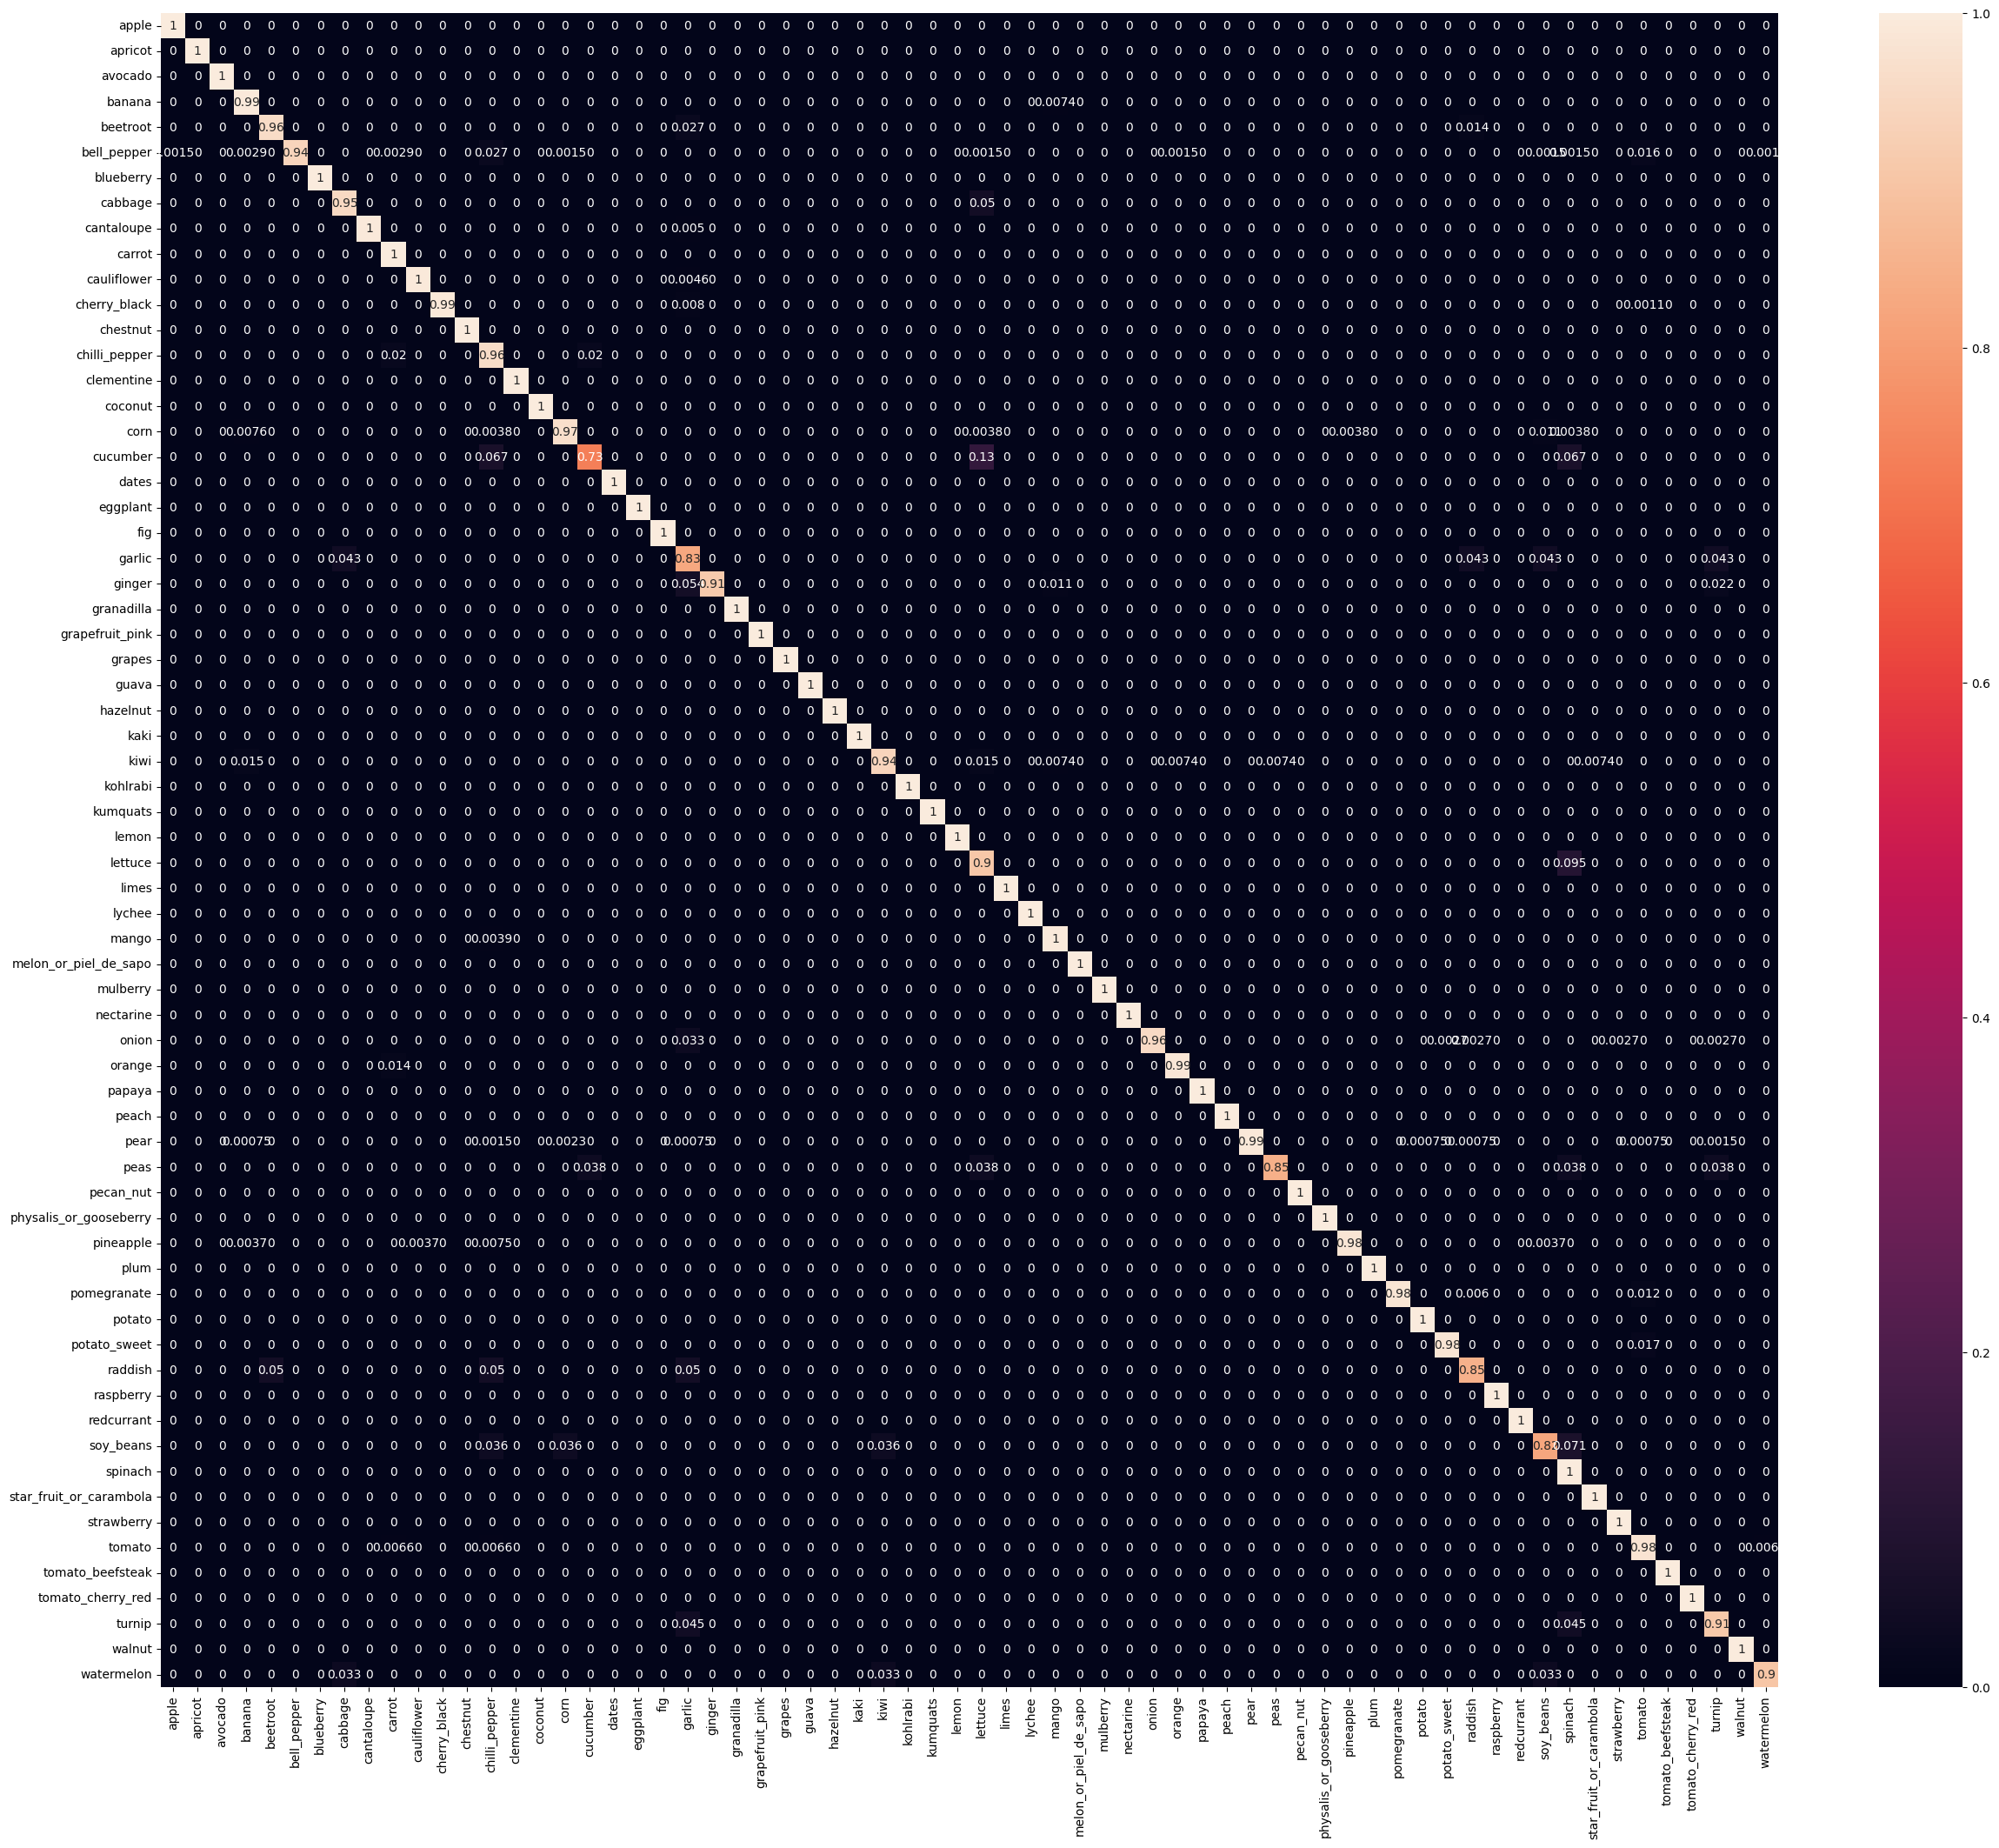

In [18]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
classes = dataset.class_to_idx.keys()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize=(30, 25))
sn.heatmap(df_cm, annot=True)
plt.savefig(f'CV_data/conf_matrix/{model_name}-output.pdf')

# Test examples

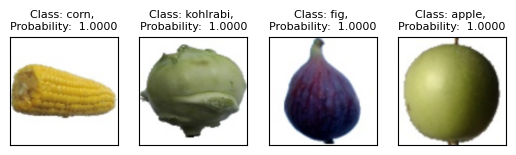

In [29]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])


# Own photos

In [30]:
import os
path = "CV_data/own_photos/"
classes = os.listdir(path)
classes = [fldr for fldr in classes if not fldr.startswith('.')]

print(classes)

transform = transforms.Compose([
    transforms.Resize(RESOLUTION),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor()
])

custom_test_dataset = datasets.ImageFolder(root=path, transform=transform)

custom_test_loader = DataLoader(dataset=custom_test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)


['banana', 'mango', 'apple']


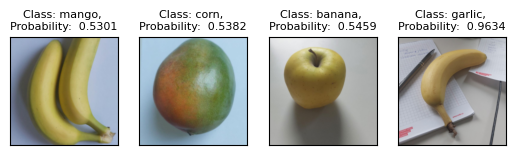

In [32]:
for batch_idx, (features, targets) in enumerate(custom_test_loader):

    features = features
    targets = targets
    break

NUM_IMG = 4
fig, axs = plt.subplots(1, NUM_IMG)
imgs = []
classes = []

for idx in range(NUM_IMG):
    nhwc_img = np.transpose(features[idx], axes=(1, 2, 0))
    imgs.append(nhwc_img)

    model.eval()
    _ , probas = model(features.to(device)[idx, None])
    probas = probas.cpu().detach().numpy()

    classes.append(
        {"class": idx_to_class[np.argmax(probas[0])],
         "proba": np.max(probas[0])})

for i, ax in enumerate(axs.flat):
    if i < len(imgs):
        ax.imshow(imgs[i])
        ax.set_title(f'Class: {classes[i]["class"]}, \nProbability:  {classes[i]["proba"]:.4f}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

In [33]:
from lib.nutrifacts import retrieve_nutrition_facts
import json

from IPython.core.display import HTML
HTML("&micro;")

print(json.dumps(retrieve_nutrition_facts(classes[2]["class"]), indent=4))

{'Food_Group': 'Fruits', 'Food Name': 'Banana', 'Energy(kcal)': 92, 'Water(g)': '75,3', 'Protein(g)': '1,1', 'Fat(g)': '0,3', 'Fatty_acids_total(g)': '0,2', 'Fatty acids saturated total(g)': '0,1', 'Carbohydrate(g)': '20', 'Sugar(g)': '15,5', 'Starch(g)': '4,5', 'Fiber dietary total(g)': '1,9', 'Na(mg)': 0.0, 'K(mg)': 374.0, 'Ca(mg)': 6.0, 'P(mg)': 28.0, 'Mg(mg)': 28.0, 'Fe(mg)': '0,3', 'Cu(mg)': '0,09', 'Se(µg)': 4.0, 'Zn(mg)': '0,25', 'Id(µg)': '2,5', 'Vitamin_D(µg)': '0', 'Vitamin_E(mg)': '0,2', 'Vitamin_K(µg)': '0,3', 'Vitamin_B1(mg)': '0,04', 'Vitamin_B2(mg)': '0,03', 'Vitamin_B6(mg)': '0,291', 'Vitamin_B12(µg)': '0', 'Vitamin_B3(mg)': '0,8', 'Vitamin_C(mg)': 8.0, 'Vitamin_A': 124.0}
{
    "Food Name": "Banana",
    "Energy(kcal)": 92,
    "Water(g)": 75.3,
    "Protein(g)": 1.1,
    "Fat(g)": 0.3,
    "Fatty_acids_total(g)": 0.2,
    "Fatty acids saturated total(g)": 0.1,
    "Carbohydrate(g)": 20.0,
    "Sugar(g)": 15.5,
    "Starch(g)": 4.5,
    "Fiber dietary total(g)": 1.9,
 